# Customer Segmentation Analysis 🕵️‍♀️

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import squarify 
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.cluster import KMeans
%matplotlib inline


## Data Prepocessing

In [3]:
data = pd.read_csv("Online-Retail-Data.csv")

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The data set has 541909 data objects and 8 attributes

In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
#Remove data that don't needed for analysis
data.drop(['Description','StockCode'], axis = 1, inplace = True)
data.shape

(541909, 6)

In [8]:
#Calculating the Missing Values % contribution in Data
total = data.isnull().sum()
percent = data.isnull().sum()/len(data)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
InvoiceNo,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,0.249267
Country,0,0.000000


In [9]:
#Remove Missing Values
data.dropna(inplace = True)
data.shape

(406829, 6)

In [10]:
#Remove canceled orders (in which Quantity is < 0)
data = data[data['Quantity']>0]
data = data[data['UnitPrice']>0]
data.shape

(397884, 6)

In [11]:
# As customer clusters may vary by geography, we will restrict the data to only United Kingdom customers, which contains most of our customers historical data.
data = data[data.Country == 'United Kingdom']
data.shape

(354321, 6)

In [12]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,354321.000000,354321.000000,354321.000000
mean,12.013795,2.963994,15552.486392
std,189.267956,17.862655,1594.527150
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15522.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


In [13]:
# Convert the type of InvoiceDate attribute from string to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

## RFM Analysis

### Recency

In [14]:
data.tail(2)

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541892,581586,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom
541893,581586,10,2011-12-09 12:49:00,7.08,13113.0,United Kingdom


In [15]:
# Compute the first and last date of transaction
min_date = data['InvoiceDate'].min()
max_date = data['InvoiceDate'].max()
print("First transaction date:", min_date)
print("Last transaction date:", max_date)

First transaction date: 2010-12-01 08:26:00
Last transaction date: 2011-12-09 12:49:00


#### The last transaction date is 09/12/2011 so we will use this day to calculate the Rencency

In [16]:
# Calculate the delta time between the last transaction date and each transaction date
data['Recency'] = (max_date - data['InvoiceDate']).dt.days
data_r = data.groupby('CustomerID').agg({'Recency' : lambda x:x.min()}).reset_index()
data_r

,CustomerID,Recency
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2
...,...,...
3915,18280.0,277
3916,18281.0,180
3917,18282.0,7
3918,18283.0,3


### Frequency

In [17]:
data_f = data.groupby('CustomerID').agg({'InvoiceNo' : lambda x:len(x)}).reset_index()
data_f.rename(columns = {'InvoiceNo':'Frequency'},inplace=True)
data_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,103
2,12748.0,4595
3,12749.0,199
4,12820.0,59


### Monetary

In [18]:
data['Monetary'] = data['Quantity']*data['UnitPrice']
data_m = data.groupby('CustomerID').agg({'Monetary' : lambda x:x.sum()}).reset_index()
data_m.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33719.73
3,12749.0,4090.88
4,12820.0,942.34


In [19]:
# Merge the rfm data to get the final RFM dataset
rfm = pd.merge(data_r,pd.merge(data_f, data_m, on='CustomerID'), on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,1,103,4196.01
2,12748.0,0,4595,33719.73
3,12749.0,3,199,4090.88
4,12820.0,2,59,942.34


In [20]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.208418,90.388010,1864.385601
std,1576.594671,99.533854,217.808385,7482.817477
min,12346.000000,0.000000,1.000000,3.750000
25%,14208.750000,17.000000,17.000000,300.280000
50%,15569.500000,50.000000,41.000000,652.280000
75%,16913.250000,142.000000,99.250000,1576.585000
max,18287.000000,373.000000,7847.000000,259657.300000


Recency: Skew:1.2447870728484713
Frequency: Skew:18.66163311873067
Monetary: Skew:20.190728787200957


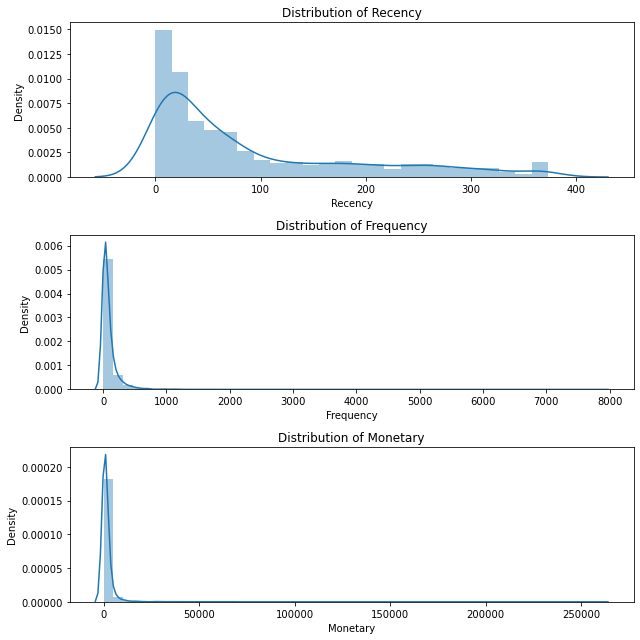

In [21]:
from scipy import stats

def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}: Skew:{}".format(column,skew))
    return

plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(rfm,'Recency')
plt.subplot(3, 1, 2)
check_skew(rfm,'Frequency')
plt.subplot(3, 1, 3)
check_skew(rfm,'Monetary')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

#### The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable.I add a small constant as log transformation demands all the values to be positive.

Recency: Skew:-0.5586976424047443
Frequency: Skew:-0.02600696239989871
Monetary: Skew:0.3694308288045071


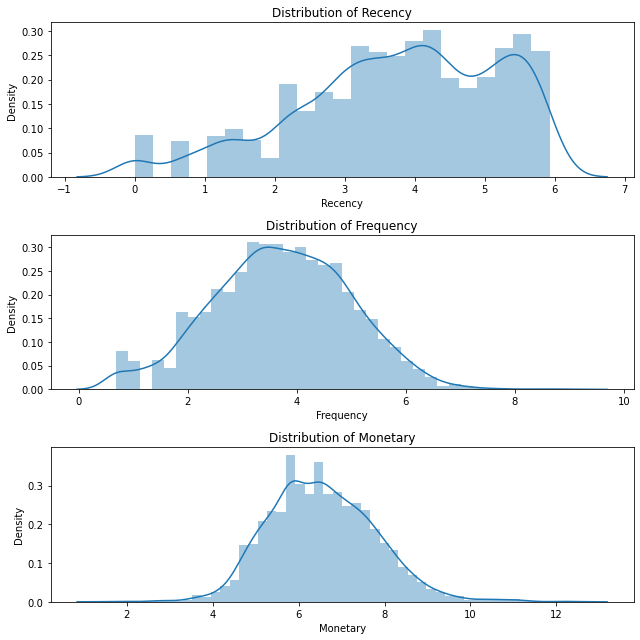

In [22]:
rfm_log = rfm.copy()
rfm_log = np.log(rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm_log,'Monetary')

plt.tight_layout()
plt.savefig('Transformed.png', format='png', dpi=1000)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_log.columns)

## Build K-means Model

### Finding the Optimal Number of Cluster by using Elbow Curve

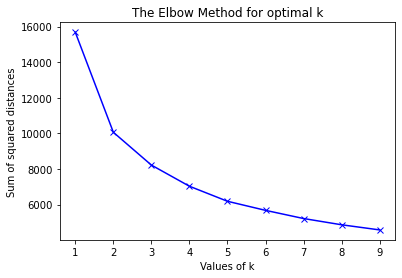

<Figure size 432x288 with 0 Axes>

In [24]:
ssd = [] #ssd = sum of squared distances
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k,random_state=0).fit(rfm_scaled)
    ssd.append(kmeans.inertia_) 
  
plt.plot(K, ssd, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Sum of squared distances')
plt.title('The Elbow Method for optimal k')
plt.show()

plt.savefig('ElbowCurve.png', format='png', dpi=1000)

We can see the drop in the sum of squared distance starts to slow down after k =4. Hence 4 is the optimal number of clusters for our analysis.

In [25]:
# Fitting model with k=4
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(rfm_scaled)
kmeans.labels_

# assign the label
rfm['Cluster'] = kmeans.labels_+1
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,325,1,77183.60,3
1,12747.0,1,103,4196.01,2
2,12748.0,0,4595,33719.73,2
3,12749.0,3,199,4090.88,2
4,12820.0,2,59,942.34,2


In [26]:
rfm_statistic = rfm.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
rfm_statistic
 

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
1         176.0      15.0    278.0   935
2          14.0     264.0   6096.0   798
3         113.0      35.0    737.0  1102
4          53.0      84.0   1264.0  1085

### Labelling Segmentation

1. Purchase long ago, purchased few and spent little -> Lost Cheap Customers
2. Bought most recently, most often and spend the most -> Best customers
3. Purchase long ago, but purchase not frequently and spend pretty much -> Almost lost
4. Haven't purchase for some time, but purchased frequently and spend a lot -> Loyal Customer

In [27]:
rfm['Segment'] = ''
rfm.loc[(rfm['Cluster']== 1),'Segment'] = 'Lost Cheap Customers'
rfm.loc[(rfm['Cluster']== 2),'Segment'] = 'Best Customer'
rfm.loc[(rfm['Cluster']== 3),'Segment'] = 'Almost Lost'
rfm.loc[(rfm['Cluster']== 4),'Segment'] = 'Loyal Customer'
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,325,1,77183.60,3,Almost Lost
1,12747.0,1,103,4196.01,2,Best Customer
2,12748.0,0,4595,33719.73,2,Best Customer
3,12749.0,3,199,4090.88,2,Best Customer
4,12820.0,2,59,942.34,2,Best Customer
...,...,...,...,...,...,...
3915,18280.0,277,10,180.60,1,Lost Cheap Customers
3916,18281.0,180,7,80.82,1,Lost Cheap Customers
3917,18282.0,7,12,178.05,1,Lost Cheap Customers
3918,18283.0,3,756,2094.88,2,Best Customer


In [28]:
rfm_statistic1 = rfm.groupby(['Segment']).agg({
        'CustomerID': ['count']
    }).round(0)
rfm_statistic1

,CustomerID
,count
Segment,
Almost Lost,1102
Best Customer,798
Lost Cheap Customers,935
Loyal Customer,1085


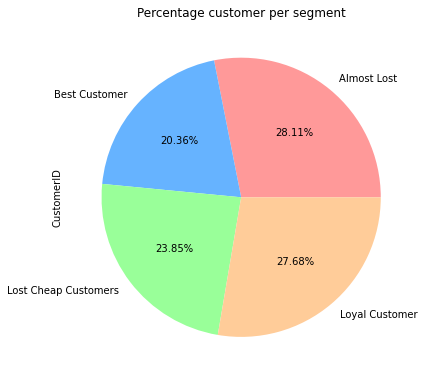

In [29]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
rfm.groupby('Segment').CustomerID.count().plot.pie(autopct = '%.2f%%', figsize = (6, 6), colors = colors)
plt.title('Percentage customer per segment')
plt.tight_layout()
plt.savefig('PieChart.png', format='png', dpi=1000)